# Comparative evaluation of surgical methods in the treatment of chronic irreparable supraspinatus tears: a biomechanical study

### **Authors**

**E. Koumantou**$^{a,*}$, **C. J. Feroussis**$^{b}$, **E. D. Pasiou**$^{a}$, **S. K. Kourkoulis**$^{a}$

### **Affiliations**

> **a** National Technical University of Athens, School of Applied Mathematical and Physical Sciences, Department of Mechanics, Laboratory of Biomechanics and Biomedical Physics, Iroon Polytechniou 5, 15773 Zografou, Greece
>
> **b** National and Kapodistrian University of Athens, School of Medicine, Mikras Asias 75, Athens, Greece

---

## **Abstract**

Chronic irreparable supraspinatus (SSP) tears are frequently treated using tensor fascia lata (TFL); however, these grafts are prone to recurrent ruptures. A TFL scaffold with seeded mesenchymal stem cells (MSCs) may increase the mechanical strength of the regenerated tendon. In this experimental study the above hypothesis is evaluated and the healing qualities of the MSC embedded scaffold are compared against the ones repaired with only a TFL allograft, from a biomechanical perspective. A number of skeletally mature male rabbits were used to create a chronic retracted SSP tear model. A tendon defect was created at the right shoulder of each specimen and was reconstructed six weeks later using a TFL allograft either with or without MSCs embedded. The rabbits were sacrificed twelve weeks after the operation and their biomechanical evaluation was based on the tendon's ultimate failure load and stiffness of each group. The results of the biomechanical analysis revealed that the MSC group demonstrated a higher tensile strength than the TFL group. The values of the mean ultimate failure load and the mean stiffness of both TFL and MSC groups were significantly lower compared to the respective values obtained for the intact rotator cuff (RC) group. It seems that bone marrow MSCs increased the mechanical strength of the supraspinatus tendon; however, the stiffness was similar between the operated groups in rabbit models. Based on the results, it could be stated that rotator cuff regeneration using MSCs appears as a promising approach; nonetheless, additional clinical evidence is required, before definite conclusions are drawn.

---


## Cell 1: Setup & Configuration

This notebook uses the centralized analysis modules from the SSP project.
All configuration (paths, group assignments, analysis parameters) is loaded from `config.json`.

**Key modules:**
- `ssp_config.py` - Configuration loading
- `utils.py` - Shared utilities (parsing, validation)
- `analysis_pipeline.py` - Core analysis functions

In [1]:
# Uncomment to install dependencies if needed
# %pip install plotly pandas numpy matplotlib scikit-learn

In [2]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Add the Data directory to path for imports
DATA_DIR = Path('.').resolve()
if str(DATA_DIR) not in sys.path:
    sys.path.insert(0, str(DATA_DIR))

# Import from centralized modules
from ssp_config import load_config, get_config_paths, get_group_ids, get_analysis_params
from utils import classify_sample, parse_filename, validate_raw_data, safe_trapezoid
from analysis_pipeline import find_best_stiffness, process_all_files, generate_statistics

# Load configuration
config, data_root, config_path = load_config()
paths = get_config_paths(config, data_root)
TFL_IDS, MSC_IDS = get_group_ids(config)
analysis_params = get_analysis_params(config)

# Set paths from config
DATA_FOLDER = paths['selected_data_dir']
RESULTS_FOLDER = paths['results_dir']

# Ensure Results folder exists
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

# Optional: Interactive plotting with Plotly
PLOTLY_AVAILABLE = False
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.express as px
    PLOTLY_AVAILABLE = True
    print("Plotly loaded - interactive plots enabled!")
except ImportError:
    print("Plotly not available. Install with: pip install plotly")
    print("Falling back to matplotlib (non-interactive) plots.")

# Set plot style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    try:
        plt.style.use('seaborn-whitegrid')
    except OSError:
        pass  # Use default style
plt.rcParams['figure.figsize'] = [10, 6]

print(f"\nConfiguration loaded from: {config_path}")
print(f"Data folder: {DATA_FOLDER}")
print(f"Results folder: {RESULTS_FOLDER}")
print(f"\nTFL group IDs: {TFL_IDS}")
print(f"MSC group IDs: {MSC_IDS}")
print(f"\nAnalysis parameters: {analysis_params}")

Plotly loaded - interactive plots enabled!

Configuration loaded from: C:\Users\elena\OneDrive - Imperial College London\2_NTUA\2_SSP_Project\Data\config.json
Data folder: C:\Users\elena\OneDrive - Imperial College London\2_NTUA\2_SSP_Project\Data\Selected_data
Results folder: C:\Users\elena\OneDrive - Imperial College London\2_NTUA\2_SSP_Project\Data\Results

TFL group IDs: ['B1', 'B10', 'B11', 'C1', 'C2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8']
MSC group IDs: ['B5', 'B6', 'B7', 'B9', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']

Analysis parameters: {'stiffness_r2_threshold': 0.99, 'stiffness_window_fraction': 0.1, 'stiffness_min_window': 5}


## Cell 2: Understanding the Classification

The `classify_sample()` function (from `utils.py`) determines which group a sample belongs to based on its filename.

**Logic:**
- Filenames contain: `SSP_YYYY-MM-DD_SubjectID_Condition.csv`
- Condition is either `NO` (non-operated control) or `OPER` (operated)
- Non-operated samples are always in the `NON` (control) group
- Operated samples are assigned to `TFL` or `MSC` based on `config.json`

In [3]:
# Demonstrate the classification function
test_files = [
    'SSP_2025-03-17_D1_NO.csv',
    'SSP_2025-03-17_D1_OPER.csv',
    'SSP_2025-03-20_D9_OPER.csv'
]

print("Classification examples:")
print("-" * 60)
for f in test_files:
    sample_id, condition, subgroup = classify_sample(f, TFL_IDS, MSC_IDS)
    print(f"{f}")
    print(f"  -> Sample: {sample_id}, Condition: {condition}, Group: {subgroup}")
    print()

Classification examples:
------------------------------------------------------------
SSP_2025-03-17_D1_NO.csv
  -> Sample: D1, Condition: NO, Group: NON

SSP_2025-03-17_D1_OPER.csv
  -> Sample: D1, Condition: OPER, Group: TFL

SSP_2025-03-20_D9_OPER.csv
  -> Sample: D9, Condition: OPER, Group: MSC



## Cell 3: Run the Analysis Pipeline

The analysis pipeline processes all CSV files and calculates:

1. **Max Load (N)** - Ultimate failure load
2. **Stiffness (N/mm)** - Slope of the stiffest linear region (using sliding window)
3. **Energy (mJ)** - Area under the load-displacement curve (work to failure)

**Stiffness Calculation:**
We use a sliding window approach to find the region with:
- Highest slope (stiffness)
- Good linearity (R² > 0.99)

In [4]:
# Run the analysis pipeline
metadata = process_all_files(
    data_dir=DATA_FOLDER,
    tfl_ids=TFL_IDS,
    msc_ids=MSC_IDS,
    r2_threshold=analysis_params['stiffness_r2_threshold'],
    window_fraction=analysis_params['stiffness_window_fraction'],
    min_window=analysis_params['stiffness_min_window']
)

if metadata is not None:
    print(f"\nProcessed {len(metadata)} samples successfully.")
    display(metadata.head(10))


Processed 46 samples successfully.


,Filename,SampleID,Subgroup,MaxLoad_N,Stiffness_N_mm,Energy_mJ,R2_Score,Linear_Start_Idx,Linear_End_Idx
0,SSP_2022-12-06_B10_NO.csv,B10,NON,483.05,243.671142,642.78800,0.996665,195,233
1,SSP_2022-12-08_B10_OPER.csv,B10,TFL,72.37,42.309454,100.46395,0.999109,260,301
2,SSP_2022-12-08_B11_NO.csv,B11,NON,395.07,213.795021,430.69940,0.998360,157,189
3,SSP_2022-12-08_B11_OPER.csv,B11,TFL,99.08,20.216689,558.37675,0.994556,47,77
4,SSP_2022-12-08_B1_OPER.csv,B1,TFL,143.12,32.482960,510.78320,0.999752,364,415
5,SSP_2022-12-08_B5_NO.csv,B5,NON,341.85,148.061518,660.86950,0.997739,267,314
6,SSP_2022-12-08_B5_OPER.csv,B5,MSC,171.97,44.279317,456.79025,0.999554,466,519
7,SSP_2022-12-17_B6_NO.csv,B6,NON,594.00,300.063613,900.69000,0.998524,85,97
8,SSP_2022-12-17_B7_NO.csv,B7,NON,653.00,304.168944,1157.26000,0.999474,110,126
9,SSP_2022-12-17_B7_OPER.csv,B7,MSC,120.00,28.511042,731.54500,0.997560,402,458


## Cell 4: Group Statistics

Generate summary statistics for each treatment group:
- **NON** - Non-operated control (intact rotator cuff)
- **TFL** - Tensor fascia lata allograft
- **MSC** - TFL + Mesenchymal stem cells

In [5]:
# Generate statistics
stats = generate_statistics(metadata)
display(stats)

# Save results to CSV
detail_path = RESULTS_FOLDER / 'Experiment_Master_Log_Detailed.csv'
metadata.to_csv(detail_path, index=False)
print(f"\nSaved detailed results to: {detail_path}")

stats_path = RESULTS_FOLDER / 'Group_Statistics_Detailed.csv'
stats.to_csv(stats_path)
print(f"Saved group statistics to: {stats_path}")

,MaxLoad_Mean,MaxLoad_Std,Stiffness_Mean,Stiffness_Std,Energy_Mean,Energy_Std,Count,Sample_List
Subgroup,,,,,,,,
MSC,154.59,19.16,43.68,11.34,670.55,351.80,10,"B5, B7, B9, D10, D11, D12, D13, D14, D15, D9"
NON,418.17,145.11,176.36,87.73,843.63,382.59,23,"B10, B11, B5, B6, B7, B9, C1, C2, D1, D10, D11..."
TFL,108.47,46.85,29.94,16.55,523.41,620.15,13,"B1, B10, B11, C1, C2, D1, D2, D3, D4, D5, D6, ..."



Saved detailed results to: C:\Users\elena\OneDrive - Imperial College London\2_NTUA\2_SSP_Project\Data\Results\Experiment_Master_Log_Detailed.csv
Saved group statistics to: C:\Users\elena\OneDrive - Imperial College London\2_NTUA\2_SSP_Project\Data\Results\Group_Statistics_Detailed.csv


## Cell 5: Visualization - Group Comparison Bar Charts

Compare the three groups across all metrics with error bars showing standard deviation.

Saved plot to: C:\Users\elena\OneDrive - Imperial College London\2_NTUA\2_SSP_Project\Data\Results\Combined_Group_Plots.png


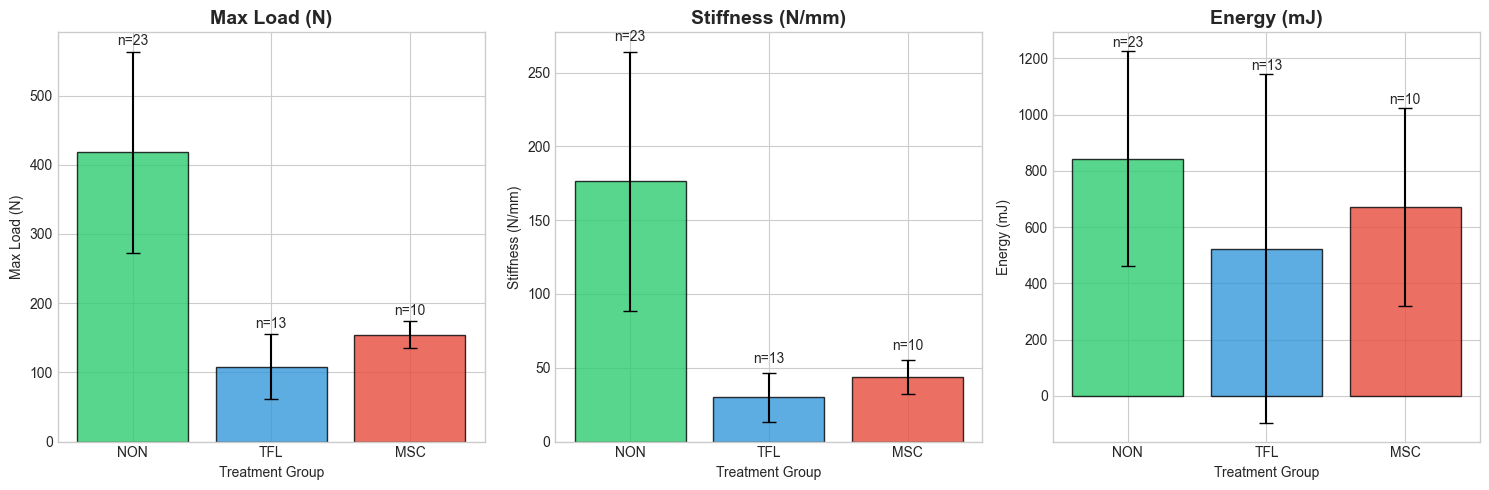

In [6]:
# Create comparison bar charts
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

groups = ['NON', 'TFL', 'MSC']
colors = ['#2ecc71', '#3498db', '#e74c3c']
metrics = ['MaxLoad_N', 'Stiffness_N_mm', 'Energy_mJ']
titles = ['Max Load (N)', 'Stiffness (N/mm)', 'Energy (mJ)']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    means = [metadata[metadata['Subgroup'] == g][metric].mean() for g in groups]
    stds = [metadata[metadata['Subgroup'] == g][metric].std() for g in groups]
    counts = [len(metadata[metadata['Subgroup'] == g]) for g in groups]
    
    bars = axes[i].bar(groups, means, color=colors, alpha=0.8, edgecolor='black')
    axes[i].errorbar(groups, means, yerr=stds, fmt='none', color='black', capsize=5)
    
    # Add sample counts
    for j, bar in enumerate(bars):
        std_val = stds[j] if not np.isnan(stds[j]) else 0
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + std_val + 5,
            f'n={counts[j]}',
            ha='center', va='bottom', fontsize=10
        )
    
    axes[i].set_title(title, fontsize=14, fontweight='bold')
    axes[i].set_ylabel(title)
    axes[i].set_xlabel('Treatment Group')

plt.tight_layout()

# Save plot
plot_path = RESULTS_FOLDER / 'Combined_Group_Plots.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Saved plot to: {plot_path}")
plt.show()

## Cell 6: Individual Load-Displacement Curves

Plot the raw load-displacement curves for each group to visualize the mechanical behavior.

C:\Users\elena\AppData\Local\Temp\ipykernel_21200\952384071.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap_name)
C:\Users\elena\AppData\Local\Temp\ipykernel_21200\952384071.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap_name)
C:\Users\elena\AppData\Local\Temp\ipykernel_21200\952384071.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap_name)
C:\Users\elena\A

Saved: C:\Users\elena\OneDrive - Imperial College London\2_NTUA\2_SSP_Project\Data\Results\Plot_NON.png


C:\Users\elena\AppData\Local\Temp\ipykernel_21200\952384071.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap_name)


Saved: C:\Users\elena\OneDrive - Imperial College London\2_NTUA\2_SSP_Project\Data\Results\Plot_TFL.png


C:\Users\elena\AppData\Local\Temp\ipykernel_21200\952384071.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(colormap_name)


Saved: C:\Users\elena\OneDrive - Imperial College London\2_NTUA\2_SSP_Project\Data\Results\Plot_MSC.png


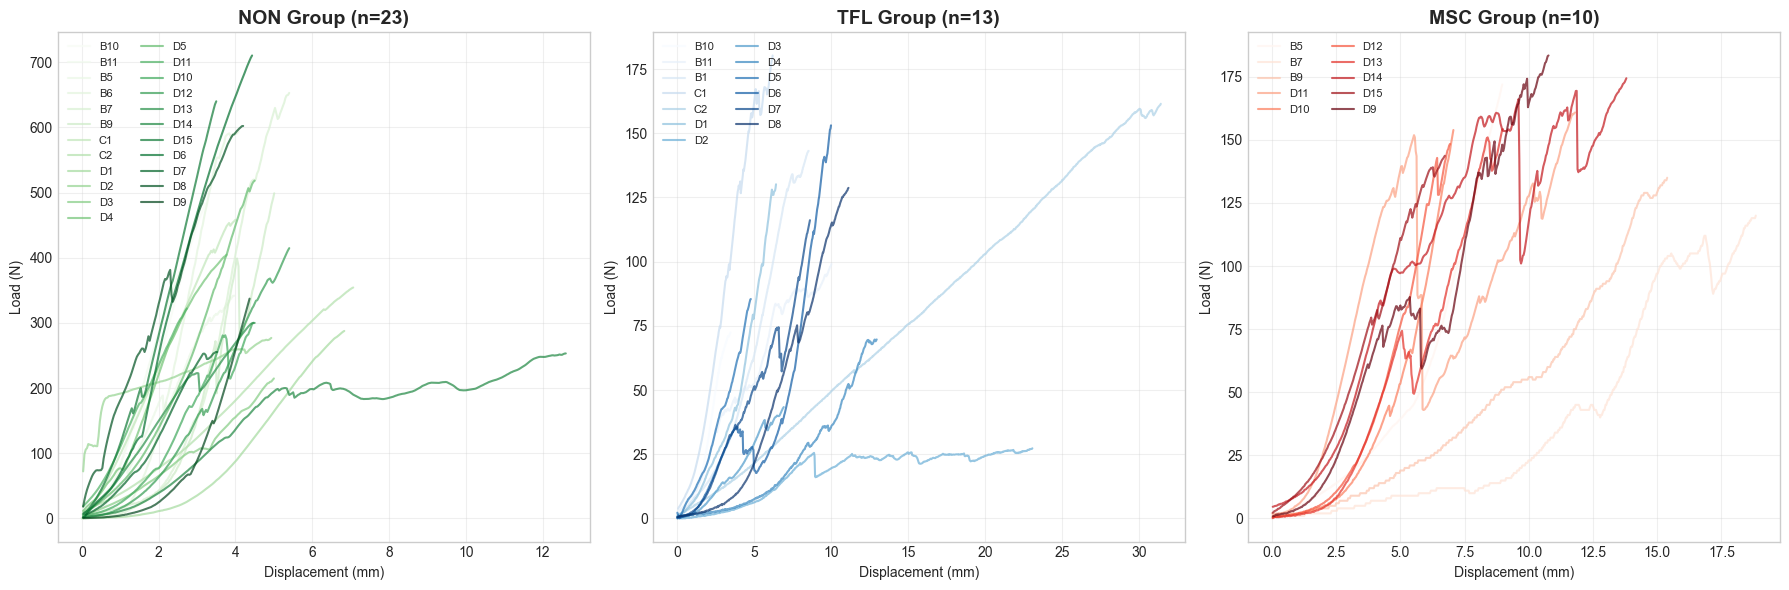

In [7]:
def plot_group_curves(group_name, group_df, ax, colormap_name='viridis'):
    """Plot load-displacement curves for a group."""
    cmap = plt.get_cmap(colormap_name)  # Use plt.get_cmap (plt.cm.get_cmap deprecated in 3.7)
    n_samples = len(group_df)
    
    for idx, (_, row) in enumerate(group_df.iterrows()):
        filename = row['Filename']
        filepath = DATA_FOLDER / filename
        
        if not filepath.exists():
            continue
            
        df = pd.read_csv(filepath)
        if 'LoadN' not in df.columns and 'LoadkN' in df.columns:
            df['LoadN'] = df['LoadkN'] * 1000
        
        # Truncate at max load
        max_idx = df['LoadN'].idxmax()
        df_trunc = df.iloc[:max_idx + 1]
        
        color = cmap(idx / max(n_samples - 1, 1))
        ax.plot(
            df_trunc['Crossheadmm'], 
            df_trunc['LoadN'],
            color=color,
            alpha=0.7,
            linewidth=1.5,
            label=row['SampleID']
        )
    
    ax.set_title(f'{group_name} Group (n={n_samples})', fontsize=14, fontweight='bold')
    ax.set_xlabel('Displacement (mm)')
    ax.set_ylabel('Load (N)')
    ax.legend(loc='upper left', fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)


# Create subplots for each group
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

group_configs = [
    ('NON', 'Greens'),
    ('TFL', 'Blues'),
    ('MSC', 'Reds')
]

for ax, (group_name, colormap) in zip(axes, group_configs):
    group_df = metadata[metadata['Subgroup'] == group_name]
    plot_group_curves(group_name, group_df, ax, colormap)

plt.tight_layout()

# Save individual group plots
for group_name, colormap in group_configs:
    fig_single, ax_single = plt.subplots(figsize=(10, 6))
    group_df = metadata[metadata['Subgroup'] == group_name]
    plot_group_curves(group_name, group_df, ax_single, colormap)
    plot_path = RESULTS_FOLDER / f'Plot_{group_name}.png'
    fig_single.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.close(fig_single)
    print(f"Saved: {plot_path}")

plt.show()

## Cell 7: Interactive Plots (Plotly)

If Plotly is available, create interactive plots for detailed exploration.

In [8]:
if PLOTLY_AVAILABLE:
    # Create interactive comparison chart
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=['Max Load (N)', 'Stiffness (N/mm)', 'Energy (mJ)']
    )
    
    colors_plotly = {'NON': '#2ecc71', 'TFL': '#3498db', 'MSC': '#e74c3c'}
    
    for i, metric in enumerate(['MaxLoad_N', 'Stiffness_N_mm', 'Energy_mJ']):
        for group in ['NON', 'TFL', 'MSC']:
            group_data = metadata[metadata['Subgroup'] == group][metric]
            fig.add_trace(
                go.Box(
                    y=group_data,
                    name=group,
                    marker_color=colors_plotly[group],
                    showlegend=(i == 0)
                ),
                row=1, col=i+1
            )
    
    fig.update_layout(
        title='Biomechanical Properties by Treatment Group',
        height=500,
        showlegend=True
    )
    fig.show()
else:
    print("Plotly not available. Skipping interactive plots.")

## Cell 8: Stiffness Visualization (All Subjects)

Show the linear region used for stiffness calculation on **every sample**, organized by group.


NON Group Example:


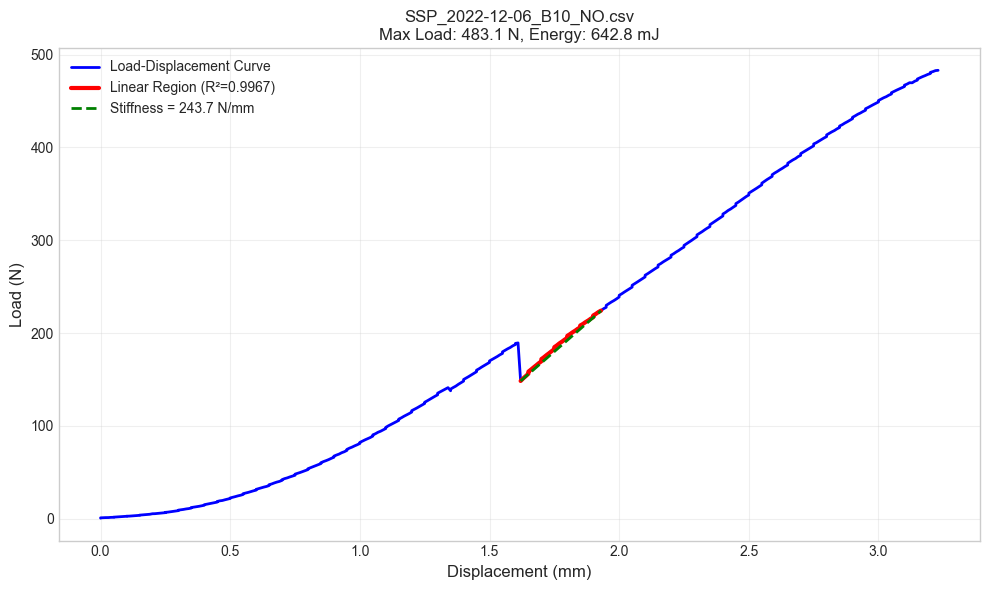


TFL Group Example:


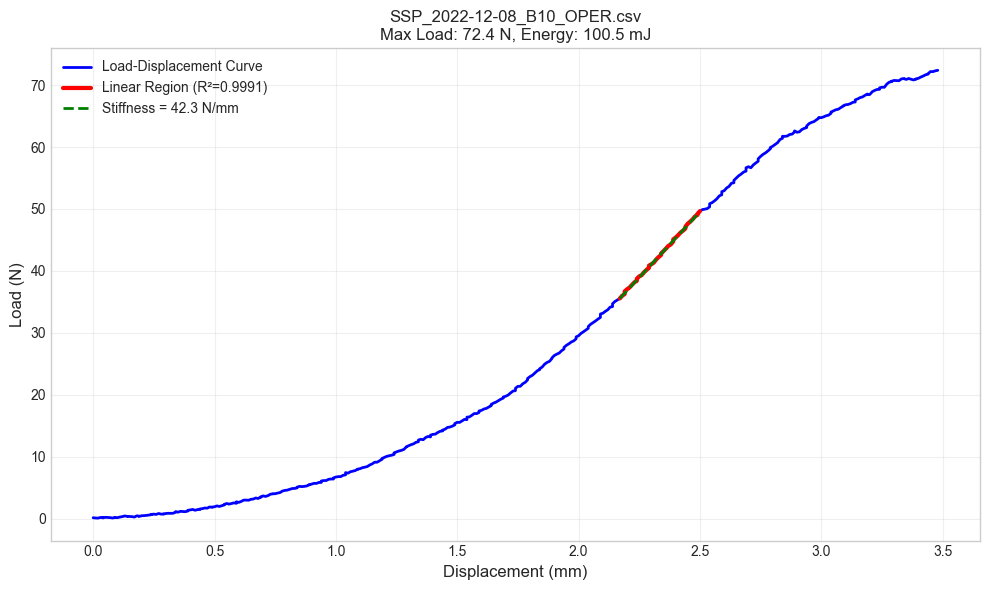


MSC Group Example:


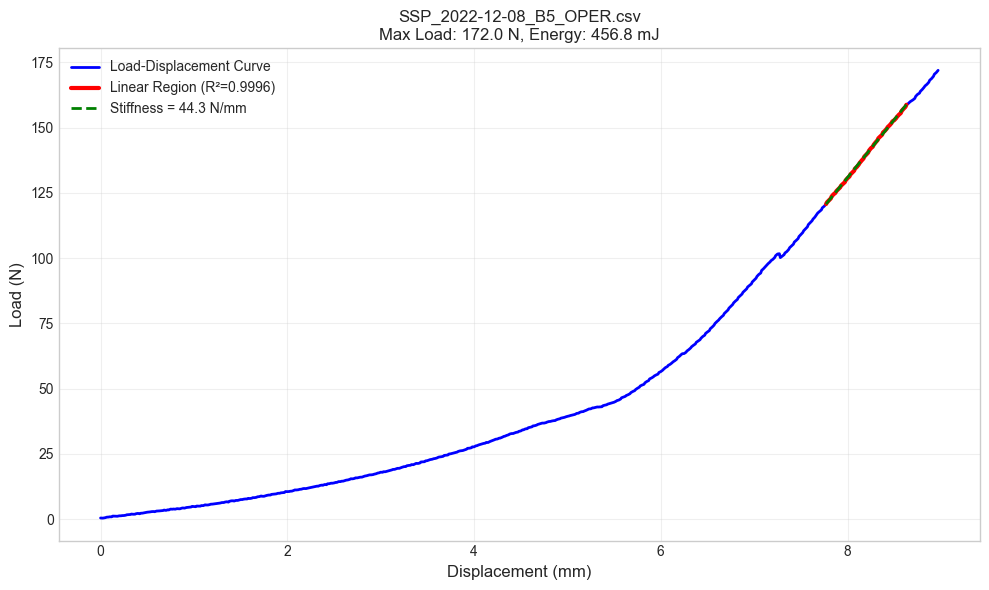

In [9]:
def plot_stiffness_region(sample_row):
    """Plot a sample's curve with the linear region highlighted."""
    filename = sample_row['Filename']
    filepath = DATA_FOLDER / filename
    
    df = pd.read_csv(filepath)
    if 'LoadN' not in df.columns and 'LoadkN' in df.columns:
        df['LoadN'] = df['LoadkN'] * 1000
    
    # Truncate at max load
    max_idx = df['LoadN'].idxmax()
    df_trunc = df.iloc[:max_idx + 1]
    
    x = df_trunc['Crossheadmm'].values
    y = df_trunc['LoadN'].values
    
    # Get linear region indices
    start_idx = int(sample_row['Linear_Start_Idx'])
    end_idx = int(sample_row['Linear_End_Idx'])
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot full curve
    ax.plot(x, y, 'b-', linewidth=2, label='Load-Displacement Curve')
    
    # Highlight linear region
    ax.plot(x[start_idx:end_idx], y[start_idx:end_idx], 'r-', 
            linewidth=3, label=f'Linear Region (R²={sample_row["R2_Score"]:.4f})')
    
    # Add linear fit line
    slope = sample_row['Stiffness_N_mm']
    x_fit = x[start_idx:end_idx]
    y_fit_start = y[start_idx]
    y_fit = y_fit_start + slope * (x_fit - x_fit[0])
    ax.plot(x_fit, y_fit, 'g--', linewidth=2, 
            label=f'Stiffness = {slope:.1f} N/mm')
    
    ax.set_xlabel('Displacement (mm)', fontsize=12)
    ax.set_ylabel('Load (N)', fontsize=12)
    ax.set_title(f'{filename}\nMax Load: {sample_row["MaxLoad_N"]:.1f} N, '
                 f'Energy: {sample_row["Energy_mJ"]:.1f} mJ', fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


# Plot ALL subjects organized by group
for group in ['NON', 'TFL', 'MSC']:
    group_df = metadata[metadata['Subgroup'] == group]
    n_samples = len(group_df)
    
    if n_samples == 0:
        continue
    
    print(f"\n{'='*60}")
    print(f"{group} GROUP ({n_samples} samples)")
    print(f"{'='*60}")
    
    for idx, (_, sample) in enumerate(group_df.iterrows()):
        print(f"\n[{idx+1}/{n_samples}] {sample['SampleID']}:")
        fig = plot_stiffness_region(sample)
        plt.show()
        plt.close(fig)  # Close to free memory

## Summary

This notebook demonstrates the biomechanical analysis pipeline for the SSP study.

**Key Findings:**
- Non-operated (NON) samples show the highest mechanical properties (intact tissue)
- MSC group shows improved properties compared to TFL-only group
- Both operated groups show significantly reduced properties vs. intact controls

**Files Generated:**
- `Results/Experiment_Master_Log_Detailed.csv` - All sample data
- `Results/Group_Statistics_Detailed.csv` - Summary statistics
- `Results/Combined_Group_Plots.png` - Comparison bar charts
- `Results/Plot_NON.png`, `Plot_TFL.png`, `Plot_MSC.png` - Individual group curves

**For interactive analysis:** Use the Streamlit app (`streamlit run app.py`)